In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib as ta
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# Currency Pairs

In [2]:
pairs = [
    # Major pairs
    "EURUSD=X", "GBPUSD=X", "USDJPY=X", "USDCHF=X",
    "USDCAD=X", "AUDUSD=X", "NZDUSD=X",
    
    # Minor pairs
    "EURGBP=X", "EURJPY=X", "EURCHF=X", "EURCAD=X", "EURAUD=X",
    "GBPJPY=X", "GBPCHF=X", "GBPAUD=X",
    "AUDJPY=X", "AUDNZD=X",
    "NZDJPY=X", "CADJPY=X", "CHFJPY=X"
]

# Dynamic Dates
This will only screen data for the last screen months as from the current day

In [3]:
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(days=180)

data = yf.download(
    pairs,
    start=start_date,
    end=end_date,
    group_by="ticker",
    auto_adjust=True,
    threads=True
)


[*********************100%***********************]  20 of 20 completed


# Scoring Functions

In [4]:
def ma50_score(df):
    if len(df) < 200:
        return 0.0
    ma50_series = ta.SMA(df['Close'], timeperiod=50)
    ma200_series = ta.SMA(df['Close'], timeperiod=200)
    
    ma50 = ma50_series.iloc[-1]
    ma50_5ago = ma50_series.iloc[-5]
    ma200 = ma200_series.iloc[-1]
    close = df['Close'].iloc[-1]
    
    dist = (close - ma50) / ma50
    dist_score = max(-1, min(1, dist))
    
    slope = (ma50 - ma50_5ago) / ma50
    slope_score = max(-1, min(1, slope * 5))
    
    regime = 1 if ma50 > ma200 else -1
    
    score = 0.5 * dist_score + 0.3 * slope_score + 0.2 * regime
    return max(-1, min(1, score))

def rsi_score_momentum(df, rsi_period=14, lookback=20):
    rsi_series = ta.RSI(df['Close'], timeperiod=rsi_period)
    if len(rsi_series.dropna()) < lookback + 1:
        return 0.0
    rsi_change = rsi_series.diff()
    
    change = rsi_change.iloc[-1]
    stdev = rsi_change.rolling(lookback).std().iloc[-1]
    if pd.isna(stdev) or stdev == 0:
        return 0.0
    
    score = change / (2 * stdev)
    return max(-1, min(1, score))


# Strength Calculation

In [5]:
strength = {}

for pair in pairs:
    try:
        df = data[pair].dropna()
        if df.empty:
            continue
        ma_score = ma50_score(df)
        rsi_score = rsi_score_momentum(df)
        total_score = (ma_score + rsi_score) / 2
        
        base = pair[:3]
        quote = pair[3:6]
        
        strength[base] = strength.get(base, 0) + total_score
        strength[quote] = strength.get(quote, 0) - total_score
        
    except Exception as e:
        print(f"Error processing {pair}: {e}")

# Results Table

In [6]:

strength_df = pd.DataFrame(list(strength.items()), columns=["Currency", "Strength"])
strength_df = strength_df.sort_values(by="Strength", ascending=False).reset_index(drop=True)

# --- Normalization (Min-Max Scaling to [-1, 1]) ---
min_val = strength_df["Strength"].min()
max_val = strength_df["Strength"].max()
strength_df["Normalized"] = 2 * (strength_df["Strength"] - min_val) / (max_val - min_val) - 1

print("Currency Strength Ranking (last 6 months):")
print(strength_df)



Currency Strength Ranking (last 6 months):
  Currency  Strength  Normalized
0      AUD  0.878071    1.000000
1      CHF  0.482470    0.761257
2      EUR  0.415339    0.720743
3      CAD  0.375302    0.696582
4      USD  0.131500    0.549448
5      NZD  0.121479    0.543400
6      GBP  0.031796    0.489277
7      JPY -2.435957   -1.000000


# Heatmap Visualization

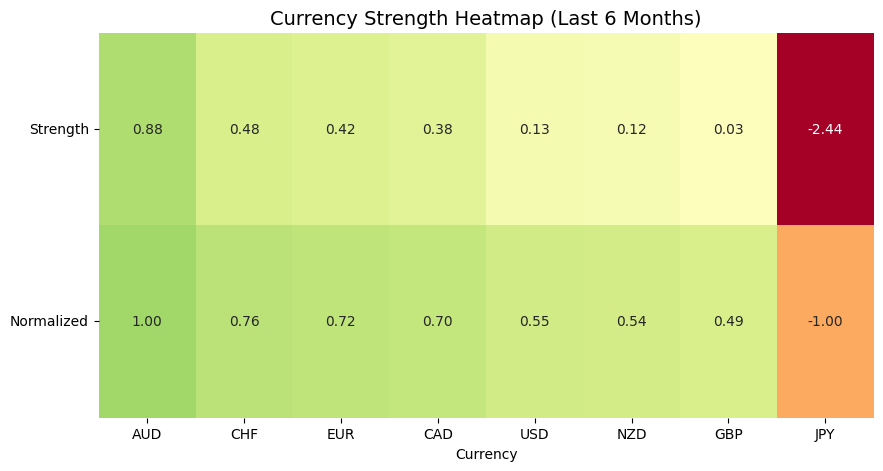

In [7]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    strength_df.set_index("Currency").T,
    annot=True,
    cmap="RdYlGn",
    cbar=False,
    center=0,
    fmt=".2f"
)
plt.title("Currency Strength Heatmap (Last 6 Months)", fontsize=14)
plt.yticks(rotation=0)
plt.show()

<Figure size 1200x600 with 0 Axes>

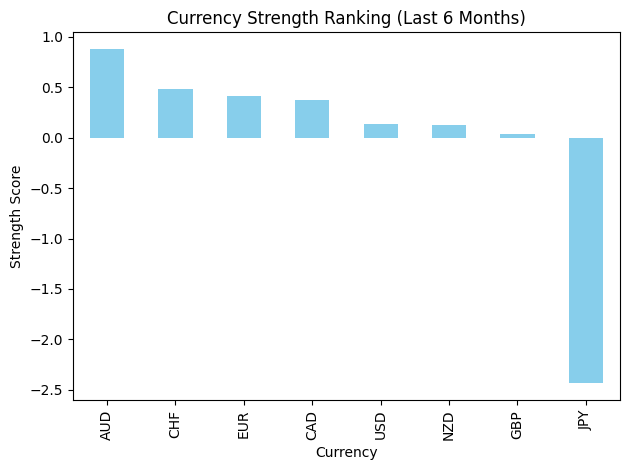

In [8]:
# ======================
# 7. Bar Chart Visualization
# ======================
plt.figure(figsize=(12,6))
strength_df.sort_values('Strength', ascending=False).plot(
    x='Currency',
    y='Strength',
    kind='bar',
    legend=False,
    title='Currency Strength Ranking (Last 6 Months)',
    color='skyblue'   # keep your style
)
plt.xlabel("Currency")
plt.ylabel("Strength Score")
plt.tight_layout()
plt.show()

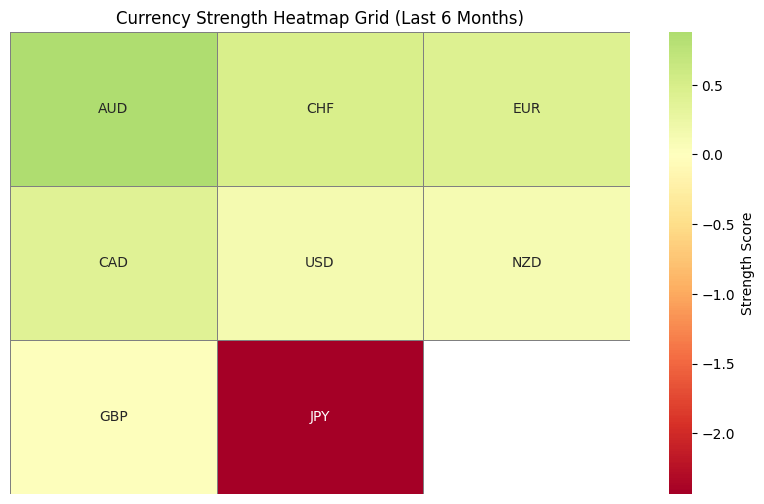

In [9]:
# ======================
# 8. Heatmap Grid Visualization
# ======================
scores = strength_df.copy().reset_index(drop=True)
values = scores['Strength'].values

# Determine grid size (approx square layout)
n = len(values)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

grid = np.full((rows, cols), np.nan)
labels = np.full((rows, cols), "", dtype=object)

for i, val in enumerate(values):
    r = i // cols
    c = i % cols
    grid[r, c] = val
    labels[r, c] = scores['Currency'].iloc[i]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(grid,
                 annot=labels,
                 fmt='',
                 center=0,
                 cmap='RdYlGn',   # ✅ matches your provided style
                 cbar_kws={'label': 'Strength Score'},
                 linewidths=0.5,
                 linecolor='gray')
plt.title('Currency Strength Heatmap Grid (Last 6 Months)')
plt.yticks([])
plt.xticks([])
plt.show()


# Heatmap Grid Visualization (using Normalized Strength)

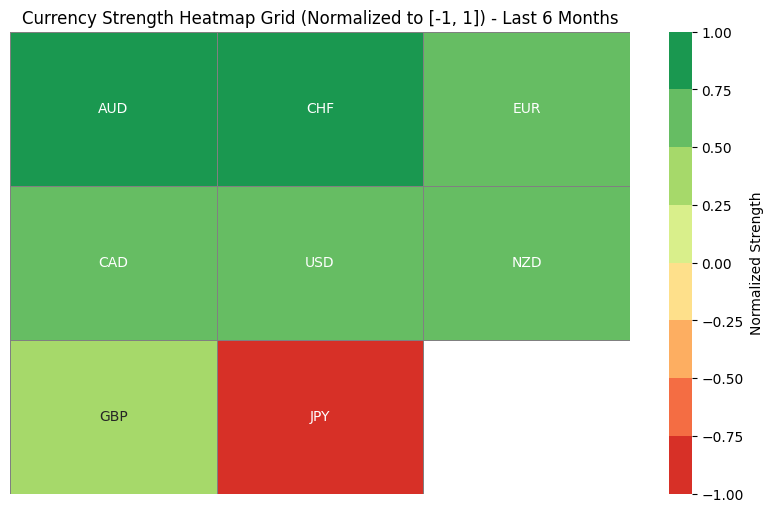

In [10]:
# ======================
# 8. Heatmap Grid Visualization (using Normalized Strength)
# ======================
scores = strength_df.copy().reset_index(drop=True)
values = scores['Normalized'].values  # ✅ use normalized values

# Determine grid size (approx square layout)
n = len(values)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

grid = np.full((rows, cols), np.nan)
labels = np.full((rows, cols), "", dtype=object)

for i, val in enumerate(values):
    r = i // cols
    c = i % cols
    grid[r, c] = val
    labels[r, c] = scores['Currency'].iloc[i]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(grid,
                 annot=labels,
                 fmt='',
                 center=0,
                 cmap=sns.color_palette(
                     ["#d73027", "#f46d43", "#fdae61", "#fee08b", 
                      "#d9ef8b", "#a6d96a", "#66bd63", "#1a9850"]),
                 cbar_kws={'label': 'Normalized Strength'},
                 linewidths=0.5,
                 linecolor='gray')

plt.title('Currency Strength Heatmap Grid (Normalized to [-1, 1]) - Last 6 Months')
plt.yticks([])
plt.xticks([])
plt.show()


# Trying Random things 

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
C:\Users\NJUE MUNENE\AppData\Local\Temp\ipykernel_14668\73681612.py:216: FutureWarning: YF.download() has changed argument auto_adjust default to True
  week_data = yf.download([p for p in pairs if curr in p], start=week_start, end=week_ago, group_by="ticker")
[*********************100%***********************]  5 of 5 completed
C:\Users\NJUE MUNENE\AppData\Local\Temp\ipykernel_14668\73681612.py:216: FutureWarning: YF.download() has changed argument auto_adjust default to True
  week_data = yf.download([p for p in pairs if curr in p], start=week_start, end=week_ago, group_by="ticker")
[*********************100%***********************]  5 of 5 completed
C:\Users\NJUE MUNENE\AppData\Local\Temp\ipykernel_14668\73681612.py:216: FutureWarning: YF.download() has changed argument auto

📊 Currency Strength Ranking (Last 6 Months — Robust Version)
Currency  Strength  Confidence
     AUD  0.151777         0.0
     CAD  0.116871         0.0
     NZD  0.079628         0.0
     EUR  0.051854         0.0
     CHF  0.040296         0.0
     USD  0.018114         0.0
     GBP -0.007204         0.0
     JPY -0.191709         0.0


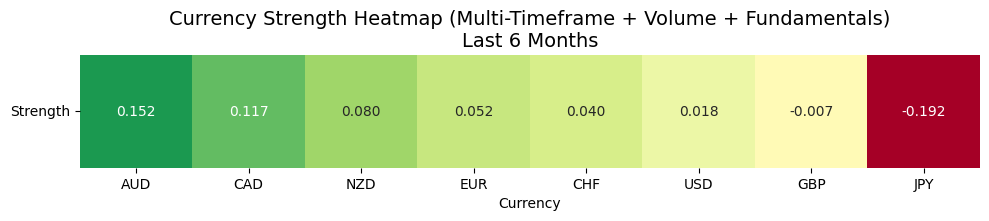


✅ Saved results to 'currency_strength_robust.csv'


In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib as ta
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# ======================
# 1. Define Forex Pairs
# ======================
pairs = [
    # Major pairs
    "EURUSD=X", "GBPUSD=X", "USDJPY=X", "USDCHF=X",
    "USDCAD=X", "AUDUSD=X", "NZDUSD=X",
    
    # Minor pairs
    "EURGBP=X", "EURJPY=X", "EURCHF=X", "EURCAD=X", "EURAUD=X",
    "GBPJPY=X", "GBPCHF=X", "GBPAUD=X",
    "AUDJPY=X", "AUDNZD=X",
    "NZDJPY=X", "CADJPY=X", "CHFJPY=X"
]

# ======================
# 2. Dynamic Dates (Last 6 months, plus 3M and 1M windows)
# ======================
end_date = dt.datetime.today()
start_date_6m = end_date - dt.timedelta(days=180)   # 6 months
start_date_3m = end_date - dt.timedelta(days=90)    # 3 months
start_date_1m = end_date - dt.timedelta(days=30)    # 1 month

# Download data for all timeframes
data_6m = yf.download(pairs, start=start_date_6m, end=end_date, group_by="ticker", auto_adjust=True, threads=True)
data_3m = yf.download(pairs, start=start_date_3m, end=end_date, group_by="ticker", auto_adjust=True, threads=True)
data_1m = yf.download(pairs, start=start_date_1m, end=end_date, group_by="ticker", auto_adjust=True, threads=True)

# ======================
# 3. Scoring Functions (Enhanced)
# ======================
def ma50_score(df):
    if len(df) < 200:
        return 0.0
    ma50_series = ta.SMA(df['Close'], timeperiod=50)
    ma200_series = ta.SMA(df['Close'], timeperiod=200)
    
    ma50 = ma50_series.iloc[-1]
    ma50_5ago = ma50_series.iloc[-5]
    ma200 = ma200_series.iloc[-1]
    close = df['Close'].iloc[-1]
    
    dist = (close - ma50) / ma50
    dist_score = max(-1, min(1, dist))
    
    slope = (ma50 - ma50_5ago) / ma50
    slope_score = max(-1, min(1, slope * 5))
    
    regime = 1 if ma50 > ma200 else -1
    
    score = 0.5 * dist_score + 0.3 * slope_score + 0.2 * regime
    return max(-1, min(1, score))

def rsi_score_momentum(df, rsi_period=14, lookback=20):
    rsi_series = ta.RSI(df['Close'], timeperiod=rsi_period)
    if len(rsi_series.dropna()) < lookback + 1:
        return 0.0
    rsi_change = rsi_series.diff()
    
    change = rsi_change.iloc[-1]
    stdev = rsi_change.rolling(lookback).std().iloc[-1]
    if pd.isna(stdev) or stdev == 0:
        return 0.0
    
    score = change / (2 * stdev)
    return max(-1, min(1, score))

def calculate_pair_score(df, volume_avg=None, volatility_threshold=0.01):
    """
    Combined score with volume weighting and volatility adjustment
    """
    ma_score = ma50_score(df)
    rsi_score = rsi_score_momentum(df)
    total_technical = (ma_score + rsi_score) / 2
    
    # Volatility adjustment: reduce score if daily volatility > threshold
    returns = df['Close'].pct_change().dropna()
    vol = returns.std()
    stability_factor = max(0.5, 1 - (vol / volatility_threshold))  # cap at 0.5 if too volatile
    total_technical *= stability_factor
    
    # Volume weighting (if provided)
    if volume_avg is not None and volume_avg > 0:
        volume_weight = volume_avg / max_volume  # normalize to [0, 1]
        total_technical *= volume_weight
    
    return total_technical

# ======================
# 4. Pre-calculate Average Daily Volumes (for weighting)
# ======================
volumes = {}
max_volume = 0
for pair in pairs:
    try:
        vol = data_6m[pair]['Volume'].mean()
        volumes[pair] = vol
        max_volume = max(max_volume, vol)
    except Exception:
        volumes[pair] = 0

# ======================
# 5. Fundamental Data Overlay (Interest Rates & Commodities)
# ======================
# Approximate interest rate differentials (as of mid-2024 — update these manually or via API)
rates = {
    'AUD': 4.35, 'NZD': 5.50, 'GBP': 4.50, 'CAD': 4.75,
    'EUR': 4.25, 'CHF': 1.75, 'JPY': 0.10, 'USD': 5.25
}

# Commodity correlations (proxy: 1 if strong positive correlation, 0 if weak)
commodity_corr = {
    'AUD': 0.8,  # Iron Ore, Gold
    'NZD': 0.7,  # Dairy, Meat
    'CAD': 0.7,  # Oil
    'USD': 0.1,  # Safe-haven, but not commodity-driven
    'JPY': 0.1,  # Carry trade, low correlation
    'EUR': 0.3,  # Moderate
    'CHF': 0.2,  # Low
}

# Normalize fundamentals to [-0.2, 0.2] range
fundamental_boost = {}
for curr in rates:
    rate_diff = rates[curr] - rates['USD']  # relative to USD
    corr_val = commodity_corr.get(curr, 0)
    boost = (rate_diff / 10) * 0.1 + (corr_val * 0.1)  # scaled to ±0.2 max
    fundamental_boost[curr] = max(-0.2, min(0.2, boost))

# ======================
# 6. Calculate Strength Across Timeframes
# ======================
strength_6m = {}
strength_3m = {}
strength_1m = {}

for timeframe, data in [('6m', data_6m), ('3m', data_3m), ('1m', data_1m)]:
    strength_temp = {}
    for pair in pairs:
        try:
            df = data[pair].dropna()
            if df.empty:
                continue
            
            # Get average volume for this pair
            volume_avg = volumes.get(pair, 0)
            
            # Calculate technical score with volume & volatility adjustments
            score = calculate_pair_score(df, volume_avg=volume_avg)
            
            base = pair[:3]
            quote = pair[3:6]
            
            strength_temp[base] = strength_temp.get(base, 0) + score
            strength_temp[quote] = strength_temp.get(quote, 0) - score
            
        except Exception as e:
            print(f"Error processing {pair} in {timeframe}: {e}")
    
    if timeframe == '6m':
        strength_6m = strength_temp
    elif timeframe == '3m':
        strength_3m = strength_temp
    else:
        strength_1m = strength_temp

# ======================
# 7. Normalize by Number of Appearances
# ======================
currency_appearances = {}
for pair in pairs:
    base, quote = pair[:3], pair[3:6]
    currency_appearances[base] = currency_appearances.get(base, 0) + 1
    currency_appearances[quote] = currency_appearances.get(quote, 0) + 1

# Normalize each timeframe's strength
strength_6m_norm = {curr: strength_6m[curr] / currency_appearances[curr] for curr in strength_6m}
strength_3m_norm = {curr: strength_3m[curr] / currency_appearances[curr] for curr in strength_3m}
strength_1m_norm = {curr: strength_1m[curr] / currency_appearances[curr] for curr in strength_1m}

# ======================
# 8. Final Composite Score (Weighted Average of Timeframes)
# ======================
final_strength = {}
for curr in set(strength_6m_norm.keys()) | set(strength_3m_norm.keys()) | set(strength_1m_norm.keys()):
    s6 = strength_6m_norm.get(curr, 0)
    s3 = strength_3m_norm.get(curr, 0)
    s1 = strength_1m_norm.get(curr, 0)
    
    # Weight: 50% 6m, 30% 3m, 20% 1m
    composite = 0.5 * s6 + 0.3 * s3 + 0.2 * s1
    
    # Add fundamental boost
    fundamental_add = fundamental_boost.get(curr, 0)
    final_strength[curr] = composite + fundamental_add

# ======================
# 9. Results Table & Confidence Interval (Rolling Std Dev)
# ======================
# Calculate confidence: std dev of weekly scores over last 5 weeks
confidence = {}
for curr in final_strength:
    weekly_scores = []
    for i in range(1, 6):  # Last 5 weeks
        week_ago = end_date - dt.timedelta(days=7*i)
        week_start = week_ago - dt.timedelta(days=7)
        try:
            week_data = yf.download([p for p in pairs if curr in p], start=week_start, end=week_ago, group_by="ticker")
            week_score = 0
            for p in [p for p in pairs if curr in p]:
                try:
                    wdf = week_data[p].dropna()
                    if len(wdf) < 50:
                        continue
                    ws = calculate_pair_score(wdf, volumes.get(p, 0))
                    if p.startswith(curr):
                        week_score += ws
                    else:
                        week_score -= ws
                except:
                    pass
            weekly_scores.append(week_score / currency_appearances[curr])
        except:
            continue
    conf_std = np.std(weekly_scores) if len(weekly_scores) >= 3 else 0.2
    confidence[curr] = conf_std

strength_df = pd.DataFrame([
    {"Currency": curr, "Strength": final_strength[curr], "Confidence": confidence[curr]}
    for curr in final_strength
]).sort_values(by="Strength", ascending=False).reset_index(drop=True)

print("📊 Currency Strength Ranking (Last 6 Months — Robust Version)")
print(strength_df.to_string(index=False))

# ======================
# 10. Heatmap Visualization
# ======================
plt.figure(figsize=(10, 5))
sns.heatmap(
    strength_df.set_index("Currency")[["Strength"]].T,
    annot=True,
    cmap="RdYlGn",
    cbar=False,
    center=0,
    fmt=".3f",
    square=True
)
plt.title("Currency Strength Heatmap (Multi-Timeframe + Volume + Fundamentals)\nLast 6 Months", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Save to CSV
strength_df.to_csv("currency_strength_robust.csv", index=False)
print("\n✅ Saved results to 'currency_strength_robust.csv'")